# Collaborative filtering
-----

In this example, we'll build a quick explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content.

We'll use an approach first made popular by the [Netflix prize](http://www.netflixprize.com/) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf). 

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

![collaborative filtering](matrix_factorization.png)
source:[ampcamp.berkeley](http://ampcamp.berkeley.edu/big-data-mini-course/movie-recommendation-with-mllib.html)

## 1. Preparations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed:
data_folder = '/home/lelarge/data/'

ML_100K_URL = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
ML_100K_FILENAME = op.join(data_folder,ML_100K_URL.rsplit('/', 1)[1])
ML_100K_FOLDER = op.join(data_folder,'ml-100k')

We start with importing a famous dataset, the [Movielens 100k dataset](https://grouplens.org/datasets/movielens/100k/). It contains 100,000 ratings (between 1 and 5) given to 1683 movies by 944 users:

In [2]:
if not op.exists(ML_100K_FILENAME):
    print('Downloading %s to %s...' % (ML_100K_URL, ML_100K_FILENAME))
    urlretrieve(ML_100K_URL, ML_100K_FILENAME)

if not op.exists(ML_100K_FOLDER):
    print('Extracting %s to %s...' % (ML_100K_FILENAME, ML_100K_FOLDER))
    ZipFile(ML_100K_FILENAME).extractall(data_folder)

Other datasets, see: [Movielens](https://grouplens.org/datasets/movielens/)

Possible soft to benchmark: [Lenskit](http://lenskit.org/)

## 2. Data analysis and formating

[Python Data Analysis Library](http://pandas.pydata.org/)

In [3]:
import pandas as pd

all_ratings = pd.read_csv(op.join(ML_100K_FOLDER, 'u.data'), sep='\t',
                          names=["user_id", "item_id", "ratings", "timestamp"])
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Let's check out a few macro-stats of our dataset

In [4]:
#number of entries
len(all_ratings)

100000

In [5]:
all_ratings['ratings'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: ratings, dtype: float64

In [6]:
# number of unique rating values
len(all_ratings['ratings'].unique())

5

In [7]:
all_ratings['user_id'].describe()

count    100000.00000
mean        462.48475
std         266.61442
min           1.00000
25%         254.00000
50%         447.00000
75%         682.00000
max         943.00000
Name: user_id, dtype: float64

In [8]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

943


In [9]:
all_ratings['item_id'].describe()

count    100000.000000
mean        425.530130
std         330.798356
min           1.000000
25%         175.000000
50%         322.000000
75%         631.000000
max        1682.000000
Name: item_id, dtype: float64

In [10]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

1682


For spliting the data into _train_ and _test_ we'll be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [11]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=42)

user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [12]:
len(user_id_train)

80000

In [13]:
len(user_id_train.unique())

943

In [14]:
len(item_id_train.unique())

1653

We see that all the movies are not rated in the train set.

In [15]:
user_id_train.iloc[:5]

75220    807
48955    474
44966    463
13568    139
92727    621
Name: user_id, dtype: int64

In [16]:
item_id_train.iloc[:5]

75220    1411
48955     659
44966     268
13568     286
92727     751
Name: item_id, dtype: int64

In [17]:
rating_train.iloc[:5]

75220    1
48955    5
44966    4
13568    4
92727    4
Name: ratings, dtype: int64

## 3. The model

We can feed our dataset to the `FactorizationModel` class - a sklearn-like object that allows us to train and evaluate the explicit factorization models.

Internally, the model uses the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.

In [18]:
import torch.nn as nn
#from torch.autograd import Variable
import torch

Let's generate [Embeddings](http://pytorch.org/docs/master/nn.html#embedding) for the users, _i.e._ a fixed-sized vector describing the user

In [19]:
embedding_dim = 3
embedding_user = nn.Embedding(total_user_id, embedding_dim)
input = torch.LongTensor([[1,2,4,5],[4,3,2,0]])
embedding_user(input)

tensor([[[-0.9320, -0.6555, -1.0655],
         [ 0.4524,  1.0263,  0.2686],
         [-1.0496, -0.7165, -0.6973],
         [-0.5366,  0.5336,  0.2259]],

        [[-1.0496, -0.7165, -0.6973],
         [-0.1849,  2.1344, -0.1380],
         [ 0.4524,  1.0263,  0.2686],
         [-1.0058,  0.2656,  1.5274]]])

Make sure to check out ```torch_utils.py``` file to find the helper functions used in this notebook.

In [20]:
import imp
import torch_utils; imp.reload(torch_utils)

from torch_utils import ScaledEmbedding, ZeroEmbedding

class DotModel(nn.Module):
    
    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):
        
        super(DotModel, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)
                
        
    def forward(self, user_ids, item_ids):
        
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)

        user_embedding = user_embedding.squeeze()
        item_embedding = item_embedding.squeeze()

        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        dot = (user_embedding * item_embedding).sum(1)

        return dot + user_bias + item_bias


In [25]:
import imp
import numpy as np

import torch.optim as optim

import torch_utils; imp.reload(torch_utils)
from torch_utils import gpu, minibatch, shuffle, regression_loss

class FactorizationModel(object):
    
    def __init__(self,
                 embedding_dim=32,
                 n_iter=10,
                 batch_size=256,
                 l2=0.0,
                 learning_rate=1e-2,
                 use_cuda=False,
                 net=None,
                 num_users=None,
                 num_items=None, 
                 random_state=None):
        
        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._l2 = l2
        self._use_cuda = use_cuda
        
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()
             
        
    def _initialize(self):
        if self._net is None:
            self._net = gpu(DotModel(self._num_users, self._num_items, self._embedding_dim),self._use_cuda)
        
        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )
        
        self._loss_func = regression_loss
    
    @property
    def _initialized(self):
        return self._optimizer is not None
    
    def __repr__(self):
        return _repr_model(self)
    
    def fit(self, user_ids, item_ids, ratings, verbose=True):
        
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)
        
        if not self._initialized:
            self._initialize()
            
        for epoch_num in range(self._n_iter):
            users, items, ratingss = shuffle(user_ids,
                                            item_ids,
                                            ratings)

            user_ids_tensor = gpu(torch.from_numpy(users),
                                  self._use_cuda)
            item_ids_tensor = gpu(torch.from_numpy(items),
                                  self._use_cuda)
            ratings_tensor = gpu(torch.from_numpy(ratingss),
                                 self._use_cuda)
            epoch_loss = 0.0

            for (minibatch_num,
                 (batch_user,
                  batch_item,
                  batch_rating)) in enumerate(minibatch(self._batch_size,
                                                         user_ids_tensor,
                                                         item_ids_tensor,
                                                         ratings_tensor)):
                
                
        
                predictions = self._net(batch_user, batch_item)

                self._optimizer.zero_grad()
                
                loss = self._loss_func(batch_rating, predictions)
                
                epoch_loss = epoch_loss + loss.data.item()
                
                loss.backward()
                self._optimizer.step()
                
            
            epoch_loss = epoch_loss / (minibatch_num + 1)

            if verbose:
                print('Epoch {}: loss {}'.format(epoch_num, epoch_loss))
        
            if np.isnan(epoch_loss) or epoch_loss == 0.0:
                raise ValueError('Degenerate epoch loss: {}'
                                 .format(epoch_loss))
    
    
    def test(self,user_ids, item_ids, ratings):
        self._net.train(False)
        user_ids = user_ids.astype(np.int64)
        item_ids = item_ids.astype(np.int64)
        
        user_ids_tensor = gpu(torch.from_numpy(user_ids),
                                  self._use_cuda)
        item_ids_tensor = gpu(torch.from_numpy(item_ids),
                                  self._use_cuda)
        ratings_tensor = gpu(torch.from_numpy(ratings),
                                 self._use_cuda)
               
        predictions = self._net(user_ids_tensor, item_ids_tensor)
        
        loss = self._loss_func(ratings_tensor, predictions)
        return loss.data.item()

In [26]:
model = FactorizationModel(embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1)

In [27]:
user_ids_train_np = user_id_train.as_matrix().astype(np.int32)
item_ids_train_np = item_id_train.as_matrix().astype(np.int32)
ratings_train_np = rating_train.as_matrix().astype(np.float32)

In [28]:
model.fit(user_ids_train_np, item_ids_train_np, ratings_train_np)

Epoch 0: loss 13.133116082300115
Epoch 1: loss 7.496939776818963
Epoch 2: loss 1.808433080021339
Epoch 3: loss 1.0783175373379188
Epoch 4: loss 0.9451855775676196
Epoch 5: loss 0.8943392981456805
Epoch 6: loss 0.8713056995898862
Epoch 7: loss 0.8526222585122797
Epoch 8: loss 0.8382889749128607
Epoch 9: loss 0.8239792834354353


In [29]:
print(model._net)

DotModel(
  (user_embeddings): ScaledEmbedding(944, 128)
  (item_embeddings): ScaledEmbedding(1683, 128)
  (user_biases): ZeroEmbedding(944, 1)
  (item_biases): ZeroEmbedding(1683, 1)
)


In [30]:
user_ids_test_np = user_id_test.as_matrix().astype(np.int64)
item_ids_test_np = item_id_test.as_matrix().astype(np.int64)
ratings_test_np = rating_test.as_matrix().astype(np.float32)
model.test(user_ids_test_np, item_ids_test_np, ratings_test_np  )

0.8865973353385925

It looks like we are already overfitting...

## 4. Analysing and interpreting the results

In [31]:
user_emb_np = model._net.user_embeddings.weight.data.numpy()

In [32]:
item_emb_np = model._net.item_embeddings.weight.data.numpy()

[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)

In [33]:
from sklearn.manifold import TSNE

item_tsne = TSNE(perplexity=30).fit_transform(item_emb_np)

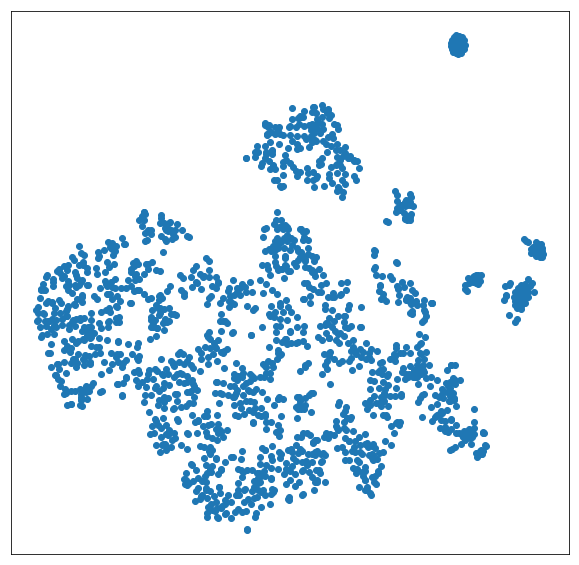

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(item_tsne[:, 0], item_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

Getting the name of the movies (there must be a better way, please provide alternate solutions!)

In [52]:
df = pd.read_csv(op.join(ML_100K_FOLDER, 'u.item'), sep='|', names=['item_id', 'item_name','date','','','','','','','','','','','','','','','','','','','','',''],encoding = "ISO-8859-1")
movies_names = df.loc[:,['item_id', 'item_name']]
movies_names = movies_names.set_index(['item_id'])
movies_names.head()

/home/lelarge/anaconda3/envs/pytorch/lib/python3.6/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


,item_name
item_id,
1,Toy Story (1995)
2,GoldenEye (1995)
3,Four Rooms (1995)
4,Get Shorty (1995)
5,Copycat (1995)


In [36]:
item_bias_np = model._net.item_biases.weight.data.numpy()

In [37]:
movies_names['biases'] = pd.Series(item_bias_np[1:].T[0], index=movies_names.index)

In [38]:
movies_names.head()

,item_name,biases
item_id,,
1,Toy Story (1995),0.133696
2,GoldenEye (1995),0.098708
3,Four Rooms (1995),0.098661
4,Get Shorty (1995),0.120266
5,Copycat (1995),0.108264


In [39]:
movies_names.shape

(1682, 2)

In [40]:
indices_item_train = np.sort(item_id_train.unique())
movies_names = movies_names.loc[indices_item_train]
movies_names.shape

(1653, 2)

In [41]:
movies_names = movies_names.sort_values(ascending=False,by=['biases'])

Best movies

In [42]:
movies_names.head(10)

,item_name,biases
item_id,,
313,Titanic (1997),0.159590
408,"Close Shave, A (1995)",0.155670
302,L.A. Confidential (1997),0.155401
272,Good Will Hunting (1997),0.155322
269,"Full Monty, The (1997)",0.153195
242,Kolya (1996),0.152459
316,As Good As It Gets (1997),0.151834
320,Paradise Lost: The Child Murders at Robin Hood...,0.151096
50,Star Wars (1977),0.150199


Worse movies

In [43]:
movies_names.tail(10)

,item_name,biases
item_id,,
907,Vermin (1998),0.028771
852,"Bloody Child, The (1996)",0.028060
1486,Girl in the Cadillac (1995),0.027855
1654,Chairman of the Board (1998),0.026460
1494,"Mostro, Il (1994)",0.026367
1290,Country Life (1994),0.026174
1621,Butterfly Kiss (1995),0.024711
1659,Getting Away With Murder (1996),0.024535
599,Police Story 4: Project S (Chao ji ji hua) (1993),0.023439


## 5. SPOTLIGHT

The code written above is a simplified version of [SPOTLIGHT](https://github.com/maciejkula/spotlight)

Once you installed it with: `conda install -c maciejkula -c pytorch spotlight=0.1.5`, you can compare the results...

In [45]:
from spotlight.datasets.movielens import get_movielens_dataset

dataset = get_movielens_dataset(variant='100K')

from spotlight.cross_validation import random_train_test_split

train, test = random_train_test_split(dataset, random_state=np.random.RandomState(42))

In [46]:
model = FactorizationModel(embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   learning_rate=1e-3,
                                   l2=1e-9,  # strength of L2 regularization
                                   use_cuda=torch.cuda.is_available(),
                                   num_users=total_user_id+1,
                                   num_items=total_item_id+1)

In [47]:
model.fit(train.user_ids,train.item_ids,train.ratings)

Epoch 0: loss 13.084344199941128
Epoch 1: loss 7.23193363901935
Epoch 2: loss 1.7397987254058258
Epoch 3: loss 1.065873310535769
Epoch 4: loss 0.9410984697221201
Epoch 5: loss 0.8957061956200418
Epoch 6: loss 0.8725117656249034
Epoch 7: loss 0.8602462101586258
Epoch 8: loss 0.849739787699301
Epoch 9: loss 0.8396177744563622


In [48]:
import torch

from spotlight.factorization.explicit import ExplicitFactorizationModel

model_spot = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim=128,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2=1e-9,  # strength of L2 regularization
                                   learning_rate=1e-3,
                                   use_cuda=torch.cuda.is_available())

In [49]:
model_spot.fit(train, verbose=True)

Epoch 0: loss 13.094079403937618
Epoch 1: loss 7.267294666435145
Epoch 2: loss 1.7425648668144322
Epoch 3: loss 1.0705132137371014
Epoch 4: loss 0.9392573350592505
Epoch 5: loss 0.892018311385867
Epoch 6: loss 0.8656685488133491
Epoch 7: loss 0.8464508524423913
Epoch 8: loss 0.8351905655257309
Epoch 9: loss 0.8227788345723213


In [50]:
item_emb_spot_np = model_spot._net.item_embeddings.weight.data.numpy()
item_bias_spot_np = model_spot._net.item_biases.weight.data.numpy()

In [53]:
movies_names['biases_S'] = pd.Series(item_bias_spot_np[1:].T[0], index=movies_names.index)

In [54]:
indices_item_train = np.sort(item_id_train.unique())
movies_names = movies_names.loc[indices_item_train]
movies_names.shape

(1653, 2)

In [56]:
movies_names = movies_names.sort_values(ascending=False,by=['biases_S'])

In [57]:
movies_names.head(10)

,item_name,biases_S
item_id,,
302,L.A. Confidential (1997),0.155696
313,Titanic (1997),0.155077
269,"Full Monty, The (1997)",0.154634
315,Apt Pupil (1998),0.149982
408,"Close Shave, A (1995)",0.149330
12,"Usual Suspects, The (1995)",0.149262
272,Good Will Hunting (1997),0.147844
427,To Kill a Mockingbird (1962),0.147753
50,Star Wars (1977),0.145862


In [58]:
movies_names.tail(10)

,item_name,biases_S
item_id,,
711,"Substance of Fire, The (1996)",0.0
1634,Etz Hadomim Tafus (Under the Domin Tree) (1994),0.0
1567,Careful (1992),0.0
1339,Stefano Quantestorie (1993),0.0
1340,"Crude Oasis, The (1995)",0.0
1447,Century (1993),0.0
1373,Good Morning (1971),0.0
852,"Bloody Child, The (1996)",0.0
857,Paris Was a Woman (1995),0.0


## 6. Further Analysis